<a href="https://colab.research.google.com/github/LeondraJames/TweetClassificationLSTM/blob/main/Tweet_Emotion_Recognition_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Twitter NLP Sentiment Multi-classification Model with a Long Short-Term Memory (LSTM), Bidirectional Recurrent Neural Network (BRNN) using Keras & TensorFlow
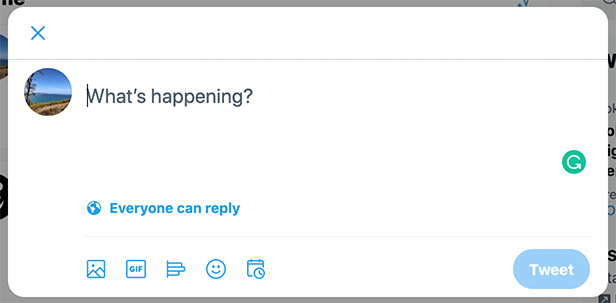
---


## Task 1: Introduction

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This project details the creation of a multi-classification Recurent Neural Network (RNN) model using Tensorflow / Keras to predict Tweet emotions. More specifically, this notebook uses a bidirectional LSTM as a means to capture additional semantics often found in sequential (language) data. This project utilizes the [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow) dataset provided by Kaggle.

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 31.0 MB/s 
     |████████████████████████████████| 212 kB 32.5 MB/s 


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.2


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
#Load data
data = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [4]:
# Review imported datsets: train, test, and validation
data

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
# Initialize training, testing, and validation datasets into their respective objects
train = data['train']
test = data['test']
val = data['validation']

In [6]:
# Create user function to extract tweets (feature) and labels (response) from training data
def get_tweet(data):
  tweets = [row['text'] for row in data]
  labels = [row['label'] for row in data]
  return tweets, labels

In [7]:
# Extract training data tweets and labels into their respecive objects
tweets, labels = get_tweet(train)

In [8]:
# Review first tweet and its label
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
#Initialize and fit tokenizer to extract top 10k freq. words from each tweet and fit on tweet texts.
tokenizer = Tokenizer(10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [11]:
#Represent words in numeric form
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [12]:
tweets[0]

'i didnt feel humiliated'

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

Text(0.5, 0, 'No. of Words')

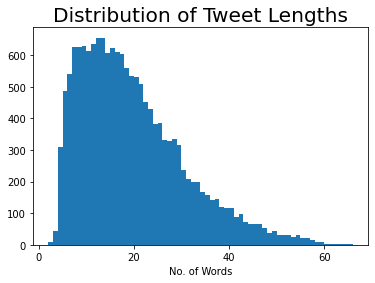

In [13]:
# Padding/truncating is necessary since our model requires a fixed input shape for all tweets
# Short tweets will require padding, long tweets will require truncation
# First, we calculate the number of words (separated by spaces) in each tweet. Plot the distribution.

lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths))) #bins set to same length of ordered tweet lengths
plt.style.use('fivethirtyeight')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('No. of Words')

In [14]:
# We believe most semantics can be captured if we truncate tweets to maxlen = 50
# For tweets that are too short, we will pad the end of the text with pad_sequences()
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
# User function to transform tweets into integers and add padding
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets) #sequences are the tokenized tweets which are assigned sequence of integers for RNN interpretation
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen = maxlen) #pad tokenized tweets up to maxlen
  return padded

In [16]:
# Apply user function and review first example
padded_train_seq = get_sequences(tokenizer, tweets)
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [17]:
# Review sentiment (label) classes
classes = set(labels)
print(classes)

{'fear', 'anger', 'love', 'sadness', 'surprise', 'joy'}


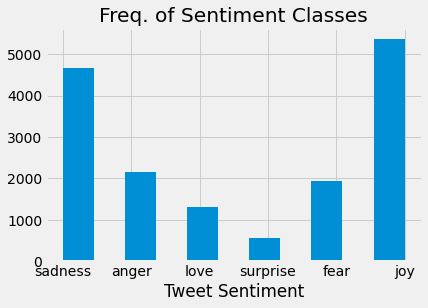

In [18]:
plt.hist(labels, bins=11)
plt.title('Freq. of Sentiment Classes')
plt.xlabel('Tweet Sentiment')
plt.show()

In [19]:
# Since the data is imbalanced, we will use appropriate evaluation metrics
from tensorflow import keras
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')] # precision-recall curve

In [20]:
# Return a dictionary (key,value pairing) of each class's class (c) and index (i)
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items()) #can't use enumerate() on dictionary

In [21]:
# Now, we have a digit for each sentiment class
class_to_index

{'anger': 1, 'fear': 0, 'joy': 5, 'love': 2, 'sadness': 3, 'surprise': 4}

In [22]:
index_to_class

{0: 'fear', 1: 'anger', 2: 'love', 3: 'sadness', 4: 'surprise', 5: 'joy'}

In [23]:
# User function to change sentiment labels from text to numbers
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [24]:
train_labels = names_to_ids(labels)

## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [25]:
!pip install keras.layers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement keras.layers (from versions: none)
ERROR: No matching distribution found for keras.layers


In [26]:
from keras.layers import Dense, Embedding, Bidirectional
from keras.models import Sequential
from keras.layers.recurrent import LSTM

In [ ]:
# Design model architecture
#def make_model(metrics=metrics):
  #if output_bias is not None:
    #output_bias = tf.keras.initializers.Constant(output_bias)
#  model = Sequential([
#                  Embedding(10000, 16, input_length=maxlen), #Each word is a 16-dim vector
#                  Bidirectional(LSTM(20, return_sequences=True)),
#                  Bidirectional(LSTM(20)),
#                  Dense(6, activation = 'softmax'),
#])

#  model.compile(
#      loss = 'sparse_categorical_crossentropy',
#      optimizer='adam',
#      metrics=metrics)          
  
#  return model

In [27]:
# Bidirectinal LSTM architecture
model = Sequential([
                  Embedding(10000, 16, input_length=maxlen), #Each word is a 16-dim vector
                  Bidirectional(LSTM(20, return_sequences=True)),
                  Bidirectional(LSTM(20)),
                  Dense(6, activation = 'softmax'),
])

# Model compilation
model.compile(
      loss = 'sparse_categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy'])          

In [28]:
#model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [ ]:
#model.load_weights(initial_weights)

In [29]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os

In [30]:
# Transform validation data and labels
val_tweets, val_labels = get_tweet(val) #Get tweets from val data
val_seq = get_sequences(tokenizer, val_tweets) #Use same tokenizer from training set on val set
val_labels = names_to_ids(val_labels) #Get numeric values for sentiment classes

In [31]:
#Preview first validation tweet and its label
val_tweets[0], val_labels[0] 

('im feeling quite sad and sorry for myself but ill snap out of it soon', 3)

In [32]:
# Prepare to train model over 20 epochs. Employ early stopping to prevent overfitting.
EPOCHS = 20
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=2)

In [33]:
h=model.fit(padded_train_seq, train_labels, validation_data = (val_seq, val_labels),epochs=EPOCHS, callbacks=[early_stopping])

Epoch 1/20
500/500 [==============================] - 171s 320ms/step - loss: 1.2927 - accuracy: 0.4805 - val_loss: 0.7846 - val_accuracy: 0.7165
Epoch 2/20
500/500 [==============================] - 157s 313ms/step - loss: 0.5834 - accuracy: 0.7720 - val_loss: 0.5532 - val_accuracy: 0.7940
Epoch 3/20
500/500 [==============================] - 162s 324ms/step - loss: 0.3701 - accuracy: 0.8715 - val_loss: 0.4924 - val_accuracy: 0.8320
Epoch 4/20
500/500 [==============================] - 157s 314ms/step - loss: 0.2565 - accuracy: 0.9176 - val_loss: 0.4396 - val_accuracy: 0.8635
Epoch 5/20
500/500 [==============================] - 156s 312ms/step - loss: 0.2076 - accuracy: 0.9333 - val_loss: 0.3904 - val_accuracy: 0.8735
Epoch 6/20
500/500 [==============================] - 156s 313ms/step - loss: 0.1565 - accuracy: 0.9507 - val_loss: 0.3895 - val_accuracy: 0.8795
Epoch 7/20
500/500 [==============================] - 154s 308ms/step - loss: 0.1271 - accuracy: 0.9603 - val_loss: 0.4424 -

In [ ]:
# If deploying Tensorboard
#run_name = 'RNN_Baseline'
#output_dir = 'model_output/'
#output_path = output_dir + run_name

#if not os.path.exists(output_path):
#  os.makedirs(output_path)

In [ ]:
#tensorboard = Tensorboard(log_dir='logs/run-name')

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

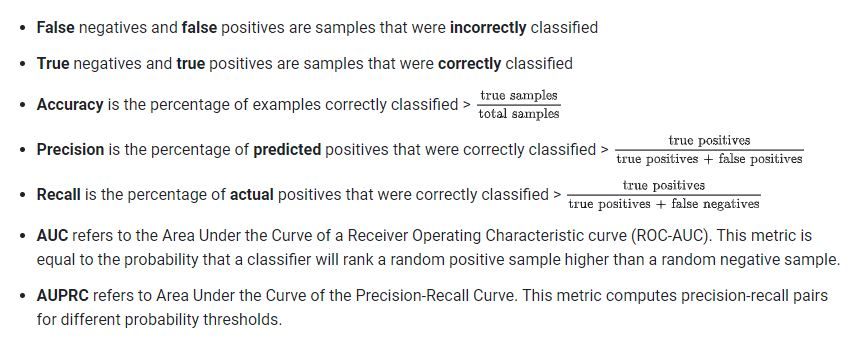

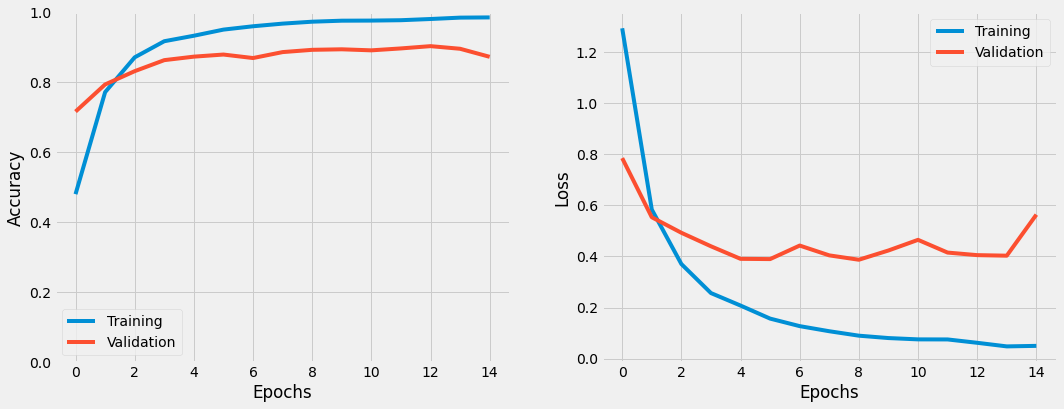

In [34]:
# Plot modeling history using the user functions from the beginning of the notebook
show_history(h)

In [37]:
# Predict on unseen (test) data
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [38]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 4s 67ms/step - loss: 0.5600 - accuracy: 0.8670


In [40]:
# Display random test set observation and its prediction (using random integer generator) 
i = random.randint(0, len(test_labels))

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p1 = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p1).astype('uint8')]

print('Predicted emotion:',pred_class)

Sentence: i left there feeling brow beaten
Emotion: sadness
Predicted emotion: sadness


In [42]:
# All predictions in test set

preds=model.predict(test_seq) 
pred_classes=np.argmax(preds,axis=1)

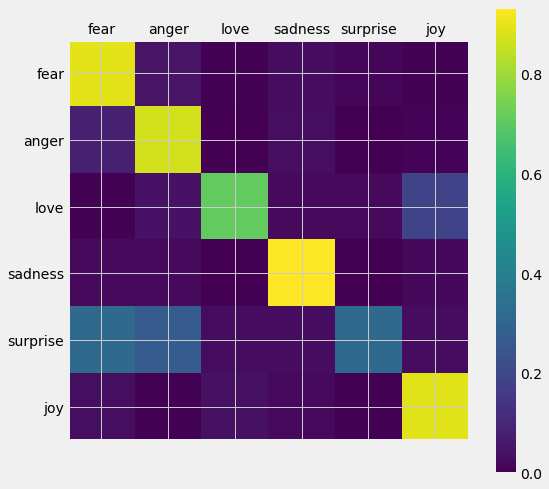

In [44]:
# Evaluate prediction confusion matrix
show_confusion_matrix(test_labels, pred_classes, list(classes))

## Recommended Next Steps

The semantics of "Love" and "Surprise" were not adequately captured by the model. There are also indications that the model is overfitting. 

It is recommended to explore additional modeling methods such as reducing variance by considering regularization methods (Dropout layers, batch normalization, etc.). Experimenting with different activation functions, learning rate, and/or optimizers may also prove helpful. Randomized search cross validation is likely a good starting point for model tuning. 

When exploring model tuning, I will likely use Tensorboard via callbacks.